In [1]:
import glob

from cartopy.crs import PlateCarree, NorthPolarStereo
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import zoom
from scipy.interpolate import LinearNDInterpolator
from tqdm.notebook import tqdm

In [2]:
nps = NorthPolarStereo()
pc = PlateCarree()

x_dst_vec = np.arange(-3500e3, 500e3, 2e3)
y_dst_vec = np.arange(-3000e3, 2000e3, 2e3)
x_dst_grd, y_dst_grd = np.meshgrid(x_dst_vec, y_dst_vec)
x_dst_grd.shape

step = 4
prods = ['sir', 'sic', 'hv']


15 results/20210103T171353_dmi_prep.nc.npz results/20210129T103213_dmi_prep.nc.npz


  0%|          | 0/15 [00:00<?, ?it/s]

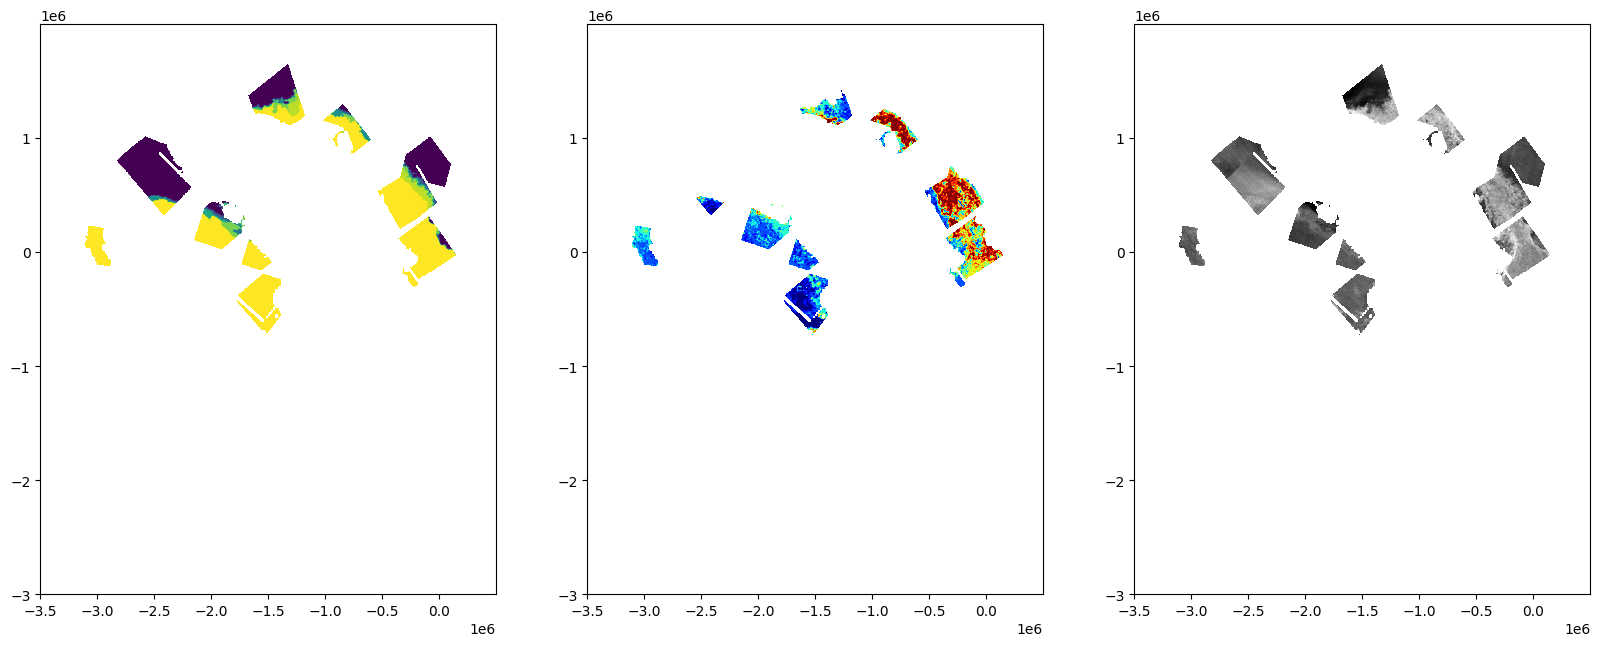

14 results/20210202T211745_dmi_prep.nc.npz results/20210220T082107_dmi_prep.nc.npz


  0%|          | 0/14 [00:00<?, ?it/s]

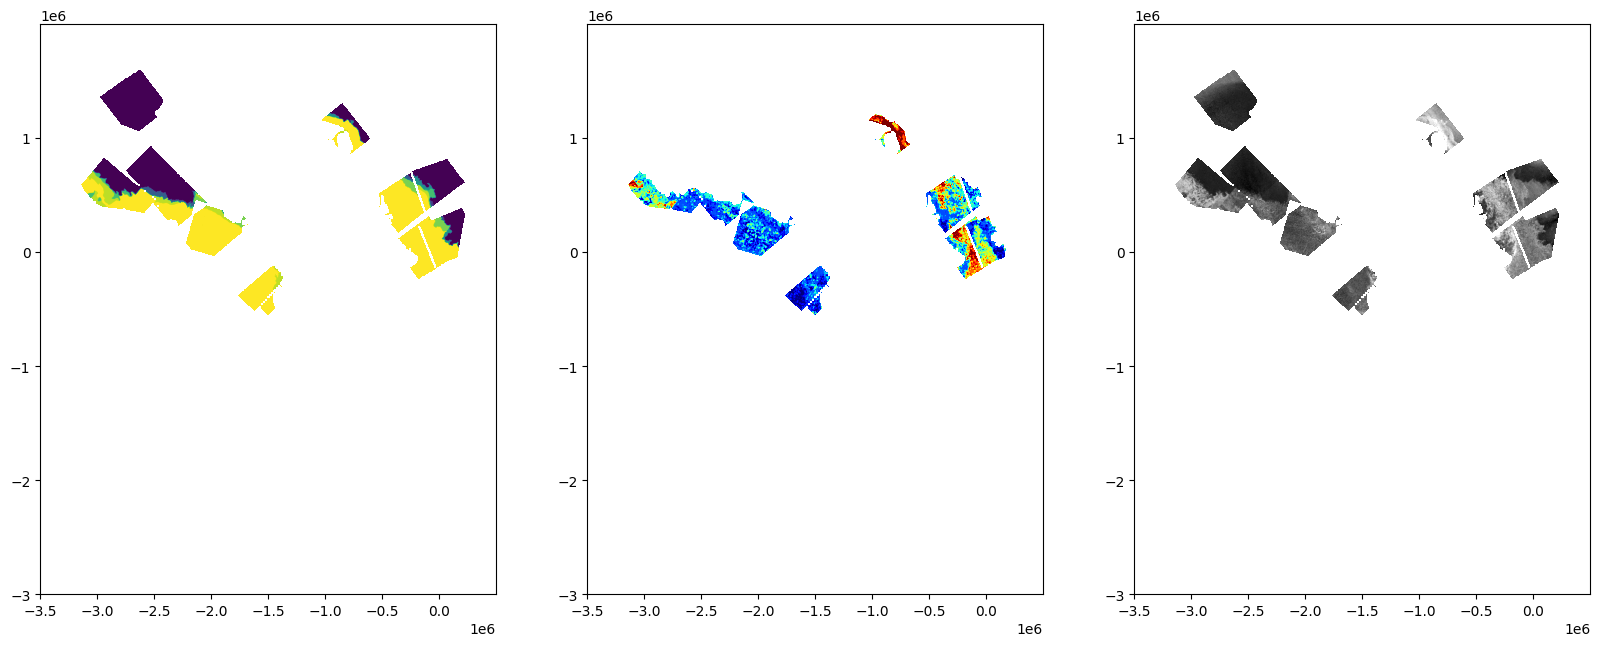

12 results/20210301T075448_dmi_prep.nc.npz results/20210331T205323_dmi_prep.nc.npz


  0%|          | 0/12 [00:00<?, ?it/s]

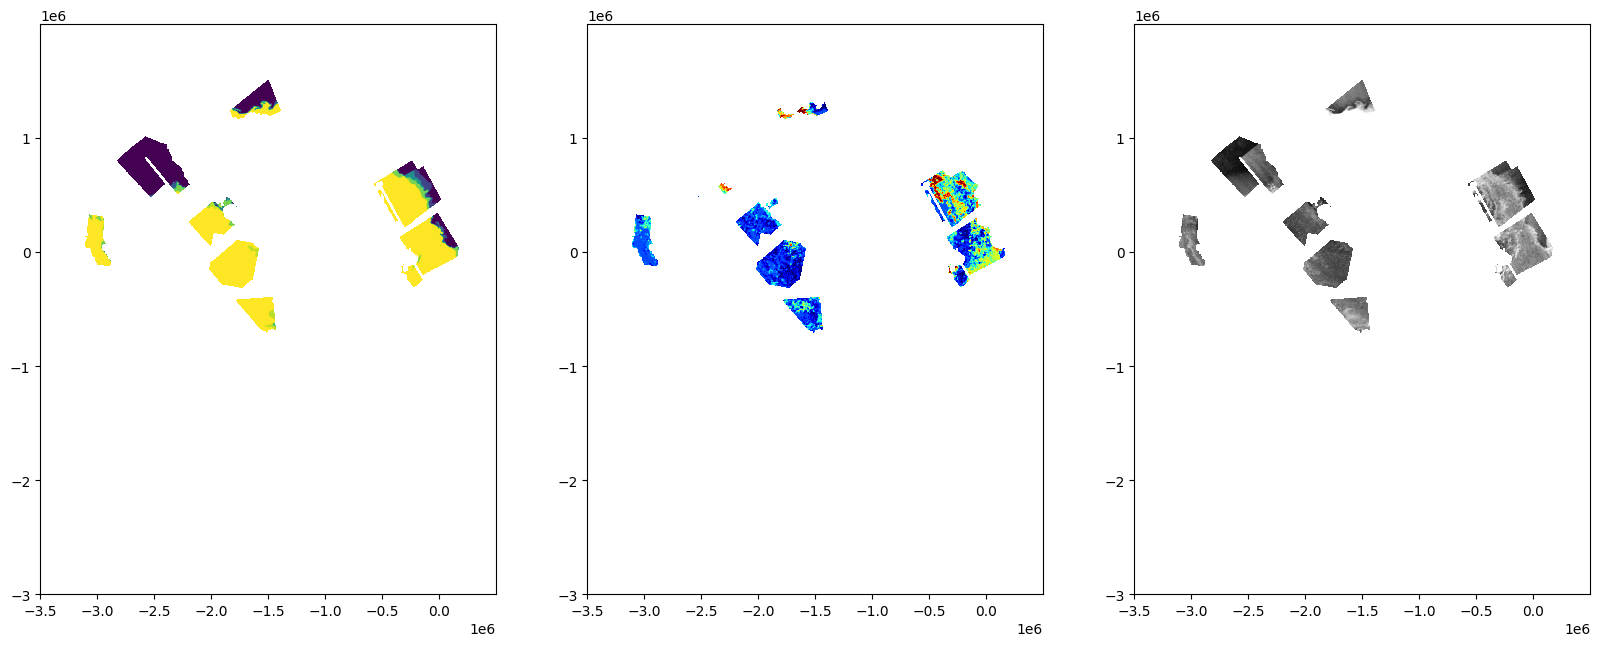

17 results/20210402T203557_dmi_prep.nc.npz results/20210429T080105_dmi_prep.nc.npz


  0%|          | 0/17 [00:00<?, ?it/s]

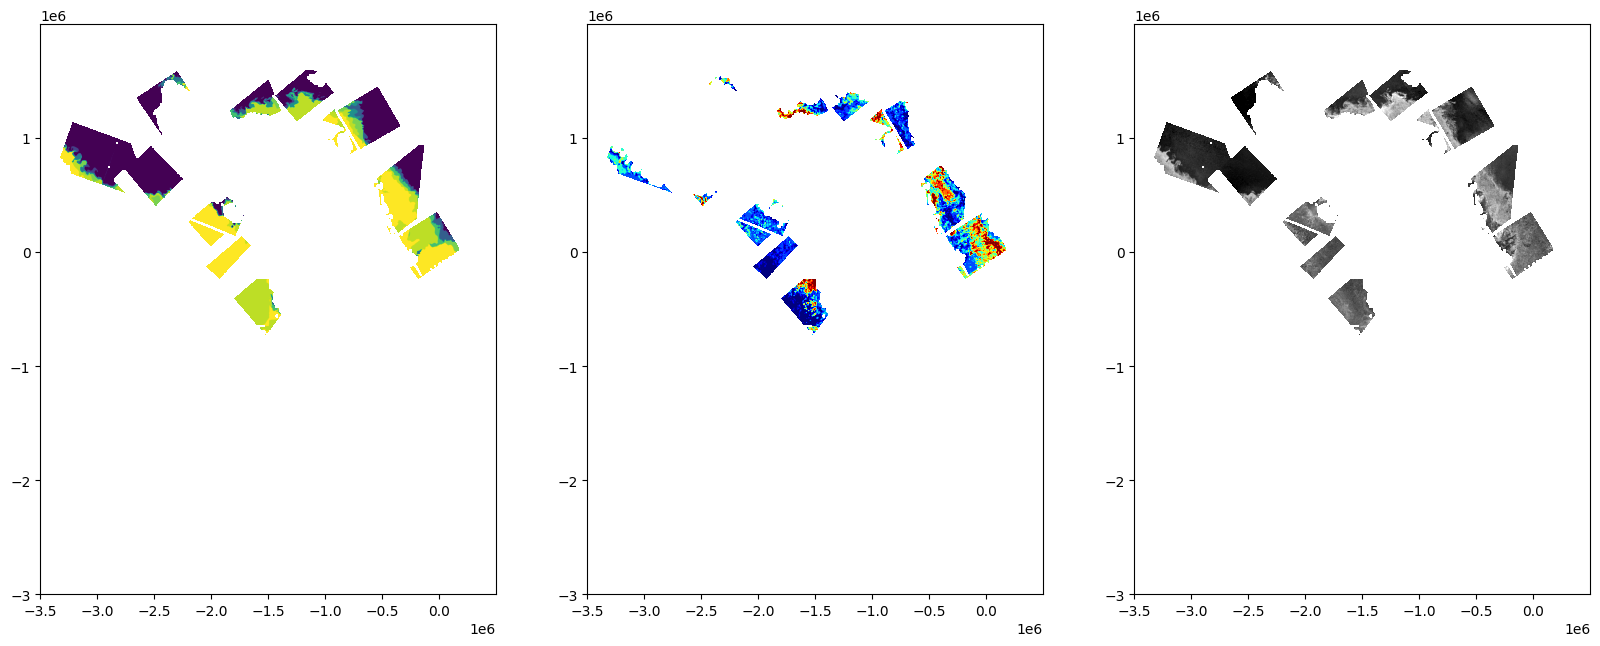

In [3]:
for m in ['01', '02', '03', '04']:
    ifiles = sorted(glob.glob(f'results/2021{m}*npz'))
    print(len(ifiles), ifiles[0], ifiles[-1])

    mos = {}
    for prod in prods:
        mos[prod] = np.zeros_like(x_dst_grd) + np.nan

    for ifile in tqdm(ifiles):
        with np.load(ifile) as d:
            ds = dict(**d)
        for prod in prods:
            ds[prod] = ds[prod][::step, ::step]

        x_src, y_src, _ = nps.transform_points(pc, ds['lon'].flatten(), ds['lat'].flatten()).T
        #plt.plot(x_src, y_src, '.')
        x_src.shape = ds['lon'].shape
        y_src.shape = ds['lon'].shape

        x_src_z = zoom(x_src, np.array(ds['sir'].shape) / np.array(x_src.shape))
        y_src_z = zoom(y_src, np.array(ds['sir'].shape) / np.array(x_src.shape))

        for prod in prods:
            i = LinearNDInterpolator((x_src_z.flat, y_src_z.flat), ds[prod].flat)
            prod_dst = i((x_dst_grd, y_dst_grd))
            mos[prod][np.isfinite(prod_dst)] = prod_dst[np.isfinite(prod_dst)]
    #plt.show()

    mos_ma = {}
    for prod in prods:
        mos_ma[prod] = np.ma.MaskedArray(mos[prod], mask=mos['sic']>11)
    mos_ma['sir'][mos_ma['sic'] < 1] = np.nan

    kwargs = dict(extent=[x_dst_vec.min(), x_dst_vec.max(), y_dst_vec.min(), y_dst_vec.max()], origin='upper')
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    axs[0].imshow(mos_ma['sic'], clim=[0, 10], **kwargs)
    axs[1].imshow(mos_ma['sir'], clim=[0, 5], cmap='jet', **kwargs)
    axs[2].imshow(mos_ma['hv'], clim=[-1, 1], cmap='gray', **kwargs)
    plt.show()

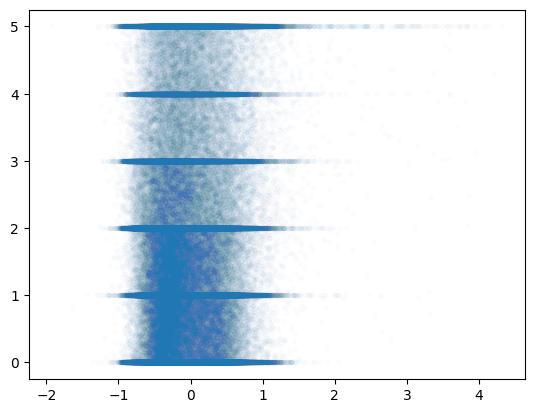

In [7]:
gpi = (mos_ma['sir'].mask == False) * np.isfinite(mos_ma['sir'])
plt.plot(mos_ma['hv'][gpi], mos_ma['sir'][gpi], '.', alpha=0.01)